# Display results
This code enables easy selection of experimental results and plotting their values

In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt

In [26]:
def satistifies_conditions(experiment, conditions):
    """ Check if experiment hyperparameters satisfy desired conditions
    """
    hp = experiment['hyperparameters']
    
    # Check if each condition satistified
    # If not, then return false
    for key, value in conditions.items():
        if key not in hp or hp[key] not in value:
            return False
    
    # All conditions are satisfied
    return True

In [3]:
def load_experiments_satisfying_conditions(conditions):
    """ Load all experiments that satisfy the given conditions.
    Return them as a list.
    """
    # Get all experiment filenames
    experiment_filenames = [f for f in os.listdir(os.getcwd()) if f[-5:] == '.json']
    
    # Initialize list of experiments that satisfy the conditions
    experiments_satisfactory = []
    
    # Load each experiment file
    for experiment_filename in experiment_filenames:
        with open(experiment_filename) as experiment_file:
            experiment = json.load(experiment_file)
            
            # Check if experiment satistifies conditions
            # If so, append to list of experiments satisfying the conditions
            if satistifies_conditions(experiment, conditions):
                experiments_satisfactory.append(experiment)
                
    return experiments_satisfactory

In [4]:
def get_per_epoch_performance(experiments, dataset, measure):
    """ For each experiment return it performance on the given dataset for the given measure
    """
    
    # Check that the dataset and measure is valid
    assert measure in {'average_accuracy', 'average_loss'}
    assert dataset in {'train', 'test'}
    
    # Infer the number of epochs and experiments
    # and create corresponding performance matrix
    num_epochs = experiments[0]['hyperparameters']['epochs']
    num_experiments = len(experiments)
    performance = np.zeros((num_experiments, num_epochs))
    
    # Extract performances
    for i, experiment in enumerate(experiments):
        performance[i, :] = experiment['results'][dataset][measure]
        
    return performance
        

# Example usage

In [5]:
# Specify conditions for experiments
conditions = {
    'architecture': {'convffnn'},
    'batch_size': {100},
    'clipping_threshold': {0.0},
    'dataset_name': {'mnist'},
    'epochs': {3},
    'initialization_scale': {'\sqrt{\frac{6}{n+m}}'},
    'lr': {0.1},
    'momentum': {0.0},
    'mu': {0.0},
    'seed': {1,2,3,4,5,6,7,8,9,10},
    'sgdtype': {'explicit'}}

In [6]:
# Load experiments and their performance
experiments = load_experiments_satisfying_conditions(conditions)
measure = 'average_accuracy'
performance = get_per_epoch_performance(experiments, 'train', measure)

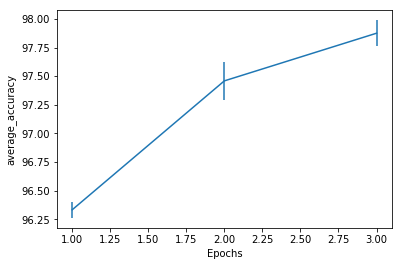

In [7]:
# Create data for plotting
epochs = performance.shape[1]
x = np.arange(1,1+epochs)
y = np.mean(performance,0)
yerr = np.std(performance,0)

# Plot!
plt.figure()
plt.errorbar(x, y, yerr=yerr)
plt.xlabel('Epochs')
plt.ylabel(measure)
plt.show()

# Mnist experiments

In [8]:
def get_minst_conditions(sgdtype, lr):
    condition = {
    'architecture': {'convffnn'},
    'batch_size': {100},
    'clipping_threshold': {0.0},
    'dataset_name': {'mnist'},
    'epochs': {1},
    'initialization_scale': {'\sqrt{\frac{6}{n+m}}'},
    'lr': {lr},
    'momentum': {0.0},
    'mu': {0.0},
    'seed': set(range(1,21)),
    'sgdtype': {sgdtype}}
    
    return condition

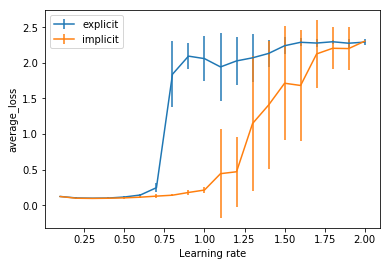

In [29]:
# Select what parameters to fix
measure = 'average_loss' # 'average_accuracy' # 
dataset = 'train'
scatter = False

# Gather the data
learning_rates = [i/10.0 for i in range(1,21)]
sgdtypes = ['explicit', 'implicit']
results = {sgdtype: {} for sgdtype in sgdtypes}
for sgdtype in sgdtypes:
    for lr in learning_rates:
        conditions = get_minst_conditions(sgdtype, lr)
        experiments = load_experiments_satisfying_conditions(conditions)
        performance = get_per_epoch_performance(experiments, dataset, measure)
        if scatter:
            results[sgdtype][lr] = performance
        else:
            results[sgdtype][lr] = (np.mean(performance), np.std(performance))

# Plot
plt.figure()
for sgdtype in sgdtypes:
    if scatter:
        for lr in learning_rates:
            y = results[sgdtype][lr]
            x = lr * np.ones(results[sgdtype][lr].shape)
            plt.scatter(x, y,color='C1' if sgdtype=='implicit' else 'C0')
    else:
        x = learning_rates
        y = [results[sgdtype][lr][0] for lr in learning_rates]
        yerr = [results[sgdtype][lr][1] for lr in learning_rates]
        plt.errorbar(x, y, yerr=yerr, label=sgdtype)
plt.xlabel('Learning rate')
plt.ylabel(measure)
plt.legend()
plt.show()

# Mnist experiments with intra-epoch losses

In [89]:
def get_minst_intra_epoch_conditions(lr):
    condition = {
    'architecture': ['convffnn'],
    'batch_size': [100],
    'clipping_threshold': [0.0],
    'dataset_name': ['mnist'],
    'epochs': [1],
    'initialization_scale': ['\sqrt{\frac{6}{n+m}}'],
    'intra_epoch': [True],
    'lr': [lr],#, 
    'momentum': [0.0],
    'mu': [0.0],
    'nodes': [50],
    'seed': list(range(1,6)),
    'sgdtype': ['explicit']
    }
    
    return condition

In [90]:
def get_per_intra_epoch_performance(experiments, measure):
    """ For each experiment return it performance on the given dataset for the given measure
    """
    
    # Check that the dataset and measure is valid
    assert measure in {'average_loss_intra_epoch', 'average_accuracy_intra_epoch'}
    
    # Infer the number of epochs and experiments
    # and create corresponding performance matrix
    num_intra = len(experiments[0]['results'][measure])
    num_experiments = len(experiments)
    performance = np.zeros((num_experiments, num_intra))
    
    # Extract performances
    for i, experiment in enumerate(experiments):
        performance[i, :] = experiment['results'][measure]
        
    return performance
        

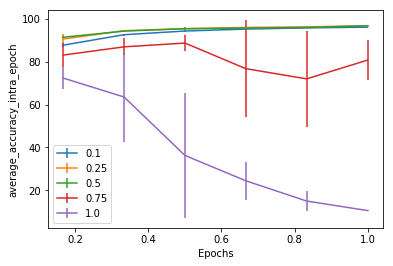

In [100]:
# Select what parameters to fix
measure = 'average_accuracy_intra_epoch' #'average_loss_intra_epoch' # 
dataset = 'train'
scatter = False

# Gather the data
learning_rates = [0.1, 0.25, 0.5, 0.75, 1.0]
sgdtypes = 'explicit'
results = {}
for lr in learning_rates:
    conditions = get_minst_intra_epoch_conditions(lr)
    experiments = load_experiments_satisfying_conditions(conditions)
    results[lr] = get_per_intra_epoch_performance(experiments, measure)
    
# Plot
plt.figure()
num_intra = len(experiments[0]['results'][measure])
x = list(np.arange(1, 1 + num_intra) / num_intra)
for lr in learning_rates:
    y = np.mean(results[lr],axis=0)
    yerr = np.std(results[lr],axis=0)
    plt.errorbar(x, y, yerr=yerr, label=lr)
plt.xlabel('Epochs')
plt.ylabel(measure)
plt.legend()
plt.show()

# Mnist experiments with clipping

In [102]:
def get_minst_clipping_conditions(sgdtype, lr):
    condition = {
    'architecture': {'convffnn'},
    'batch_size': {100},
    'clipping_threshold': {1.0},
    'dataset_name': {'mnist'},
    'epochs': {1},
    'initialization_scale': {'\sqrt{\frac{6}{n+m}}'},
    'lr': {lr},
    'momentum': {0.0},
    'mu': {0.0},
    'seed': set(range(1,21)),
    'sgdtype': {sgdtype}}
    
    return condition

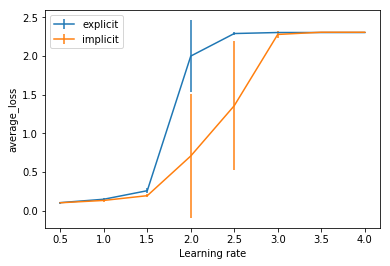

In [104]:
# Select what parameters to fix
measure = 'average_loss' # 'average_accuracy' # 
dataset = 'train'

# Gather the data
learning_rates = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4]
#[0.25, 0.5, 0.75, 1.0,1.25,1.5,1.75,2.0]#[i/10.0 for i in range(1,21)]
sgdtypes = ['explicit', 'implicit']
results = {sgdtype: {} for sgdtype in sgdtypes}
for sgdtype in sgdtypes:
    for lr in learning_rates:
        conditions = get_minst_clipping_conditions(sgdtype, lr)
        experiments = load_experiments_satisfying_conditions(conditions)
        performance = get_per_epoch_performance(experiments, dataset, measure)
        results[sgdtype][lr] = (np.mean(performance), np.std(performance))

# Plot
plt.figure()
for sgdtype in sgdtypes:
    x = learning_rates
    y = [results[sgdtype][lr][0] for lr in learning_rates]
    yerr = [results[sgdtype][lr][1] for lr in learning_rates]
    plt.errorbar(x, y, yerr=yerr, label=sgdtype)
plt.xlabel('Learning rate')
plt.ylabel(measure)
plt.legend()
plt.show()

# Autoencoder experiments

In [14]:
def get_minst_autoencoder_conditions(sgdtype, lr):
    condition = {
    "architecture": {"autoencoder"},
    "batch_size": {100},
    "clipping_threshold": {0.0},
    "dataset_name": {"mnist_autoencoder"},
    "epochs": {1},
    "initialization_scale": {"\\sqrt{\frac{6}{n+m}}"},
    "lr": {lr},
    "momentum": {0.0},
    "mu": {0.0},
    "seed": set(range(1,21)),
    "sgdtype": {sgdtype},
    "data_type": {"autoencoder"}
    }
    
    return condition

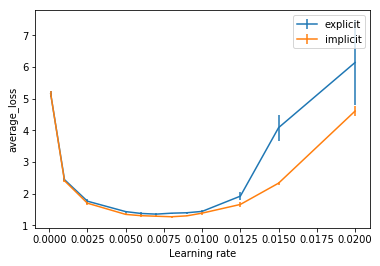

In [15]:
# Select what parameters to fix
dataset = 'train'

# Gather the data
measure = 'average_loss'
learning_rates = [0.0001,0.001, 0.0025, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.0125, 0.015, 0.02]
sgdtypes = ['explicit', 'implicit']
results = {sgdtype: {} for sgdtype in sgdtypes}
for sgdtype in sgdtypes:
    for lr in learning_rates:
        conditions = get_minst_autoencoder_conditions(sgdtype, lr)
        experiments = load_experiments_satisfying_conditions(conditions)
        performance = get_per_epoch_performance(experiments, dataset, measure)
        results[sgdtype][lr] = (np.mean(performance), np.std(performance))

# Plot
plt.figure()
for sgdtype in sgdtypes:
    x = learning_rates
    y = [results[sgdtype][lr][0] for lr in learning_rates]
    yerr = [results[sgdtype][lr][1] for lr in learning_rates]
    plt.errorbar(x, y, yerr=yerr, label=sgdtype)
plt.xlabel('Learning rate')
plt.ylabel(measure)
plt.legend()
plt.show()